# Семинар 07 - Бустинг

В качестве источника используется:
- [Глава 7](https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb) из Книги [Aurélien Geron](https://github.com/ageron)
- материалы [mlcourse.ai](https://mlcourse.ai) от [Юрия Кашницкого](https://yorko.github.io) и [OpenDataScience](https://ods.ai)

<a id="Content"></a>
# Содержание
0. [AdaBoost](#0)
1. [Gradient Boosting](#1)
   - [Реализация градиентного бустинга для задачи регрессии](#1.1)
   - [Влияние разного количества базовых алгоритмов на градиентный бустинг](#1.2)
   - [Влияние разной глубины базовых алгоритмов на градиентный бустинг](#1.3)
   - [Методы борьбы с переобучением](#1.4)
2. [Фреймворки для градиентного бустинга](#2)
   - [LightGBM](#2.1)
   - [XGboost](#2.2)
   - [CatBoost](#2.3)
3. [Полезные ссылки](#3)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

%matplotlib inline

seed = 42
np.random.seed(seed)

In [2]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
        
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)

    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

 Загрузим синтетический набор данных "Луны"

In [3]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

<a id="0"></a>
# 0. AdaBoost

![img](img/bagging-vs-boosting.png)

Три основных идеи в **AdaBoost**:
1. AdaBoost обьъединяет несколько "слабых" классификаторов.
2. Вклад каждой обученной модели разный.
3. Каждая следующая модель обучена так, что берёт во внимание ошибку предыдущих (неправильно классифицированным объектам даётся больший вес).

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [7]:
# бустинг над решающим пнем 
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=100, algorithm="SAMME.R",
                             learning_rate=0.5, random_state=seed)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)

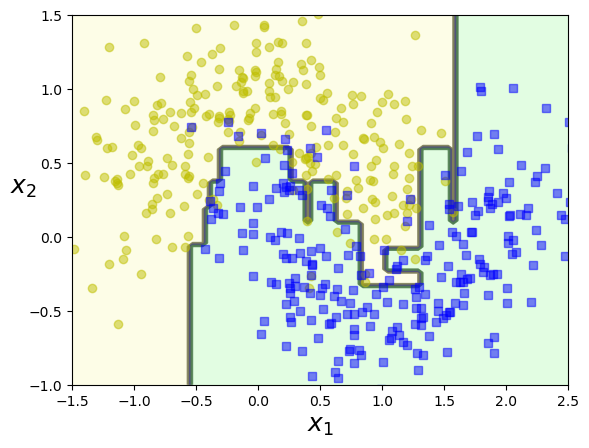

In [8]:
plot_decision_boundary(ada_clf, X, y)
plt.show()

Давайте попробуем посмотреть что происходит по шагам. В качестве иллюстрации будем использовать SVM.

In [9]:
from sklearn.svm import SVC

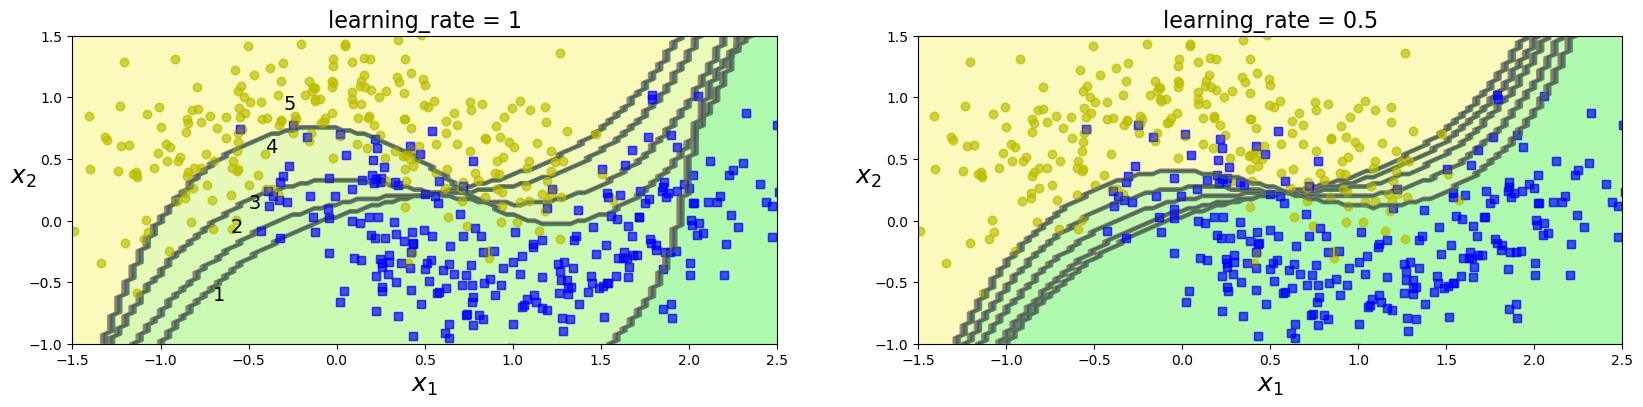

In [10]:
m = len(X_train)

plt.figure(figsize=(20, 4))

for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)

    for i in range(5):
        # init and fit
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=seed)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)

        # predict
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)

        # plot
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

<a id="1"></a>
# 1. Gradient Boosting для регрессии

![img](img/gradient_boosting_reg.jpg)

Основные идеи **Gradient Boosting** для задачи регрессии:
1. Обычно первым деревом в градиентном бустинге является одна вершина - среднее значение
2. Все последующие деревья строятся для предсказания остатка от предыдущего предсказания: $y_{i-1} - y_{i}$
3. Окончательные предсказания складываются из суммы предсказаний всех деревьев

<a id="1.1"></a>
## 1.1. Реализация градиентного бустинга для задачи регрессии
Для начала посмотрим на игрушечных данных

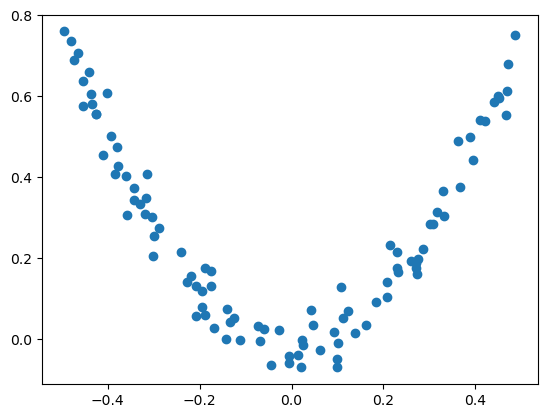

In [11]:
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

plt.scatter(X, y)
plt.show()

Построим решающее дерево

In [12]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=seed)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

**Задание 0:** Постройте ещё два DecisionTreeRegressor(max_depth=2, random_state=42), которые будут исправлять ошибку предыдущих.

In [14]:
# YOUR_CODE_HERE
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=seed)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [15]:
# YOUR_CODE_HERE
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=seed)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [16]:
# зададим новую точку не из обуающей выборки
X_new = np.array([[0.8]])

ошибка на i-ом объекте зависит от веса (ошибки всех предыдущих моделей в ансамбле) на ошибку последней модели ансамбля 

In [17]:
# получим суммарное предсказание 3 деревьев по ансамблю
y_pred = tree_reg1.predict(X) + tree_reg2.predict(X) + tree_reg3.predict(X)

In [18]:
def plot_predictions(regressors, X, y, axes, label=None, 
                     style="r-", data_style="b.", data_label=None):

    # get predict
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
     for regressor in regressors)

    # plot
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

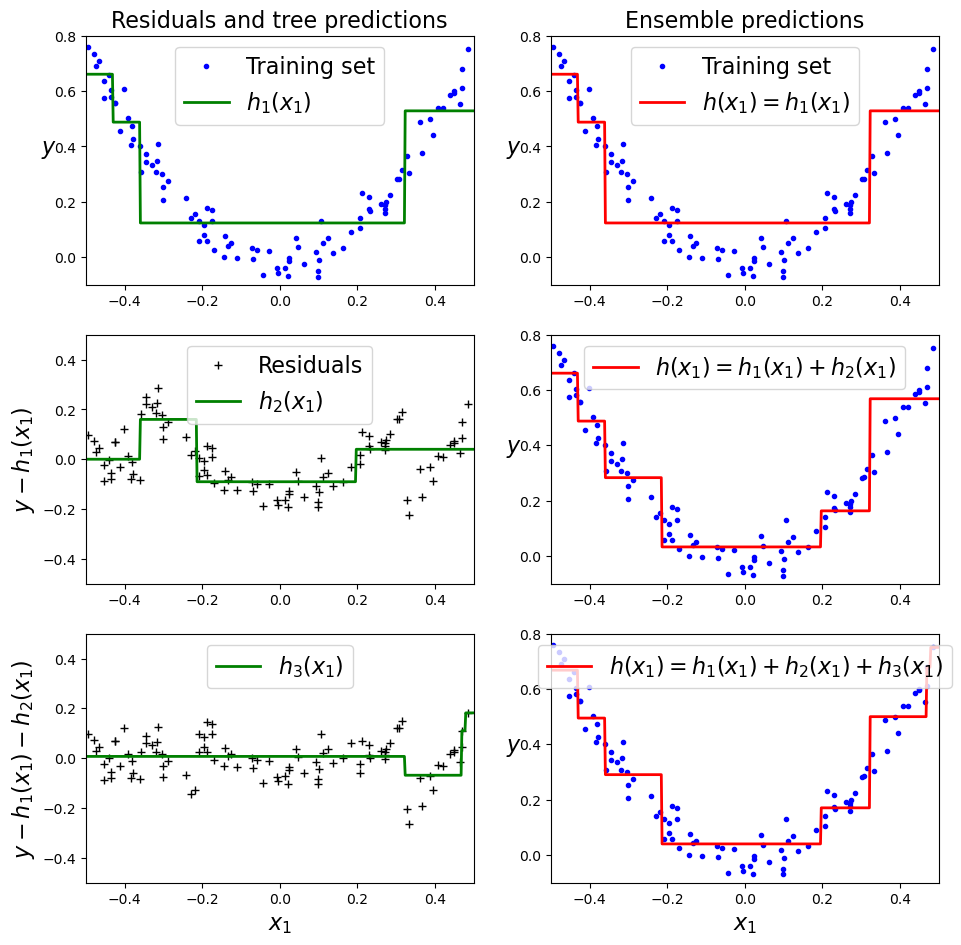

In [19]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

<a id="1.2"></a>
## 1.2. Влияние разного количества базовых алгоритмов на градиентный бустинг

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

Посмотрим, как изменятся результаты при разном количестве базовых классификаторов

In [21]:
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1,
                                 random_state=seed)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

In [22]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, 
                                      n_estimators=200,
                                      learning_rate=1,
                                      random_state=seed)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=200,
                          random_state=42)

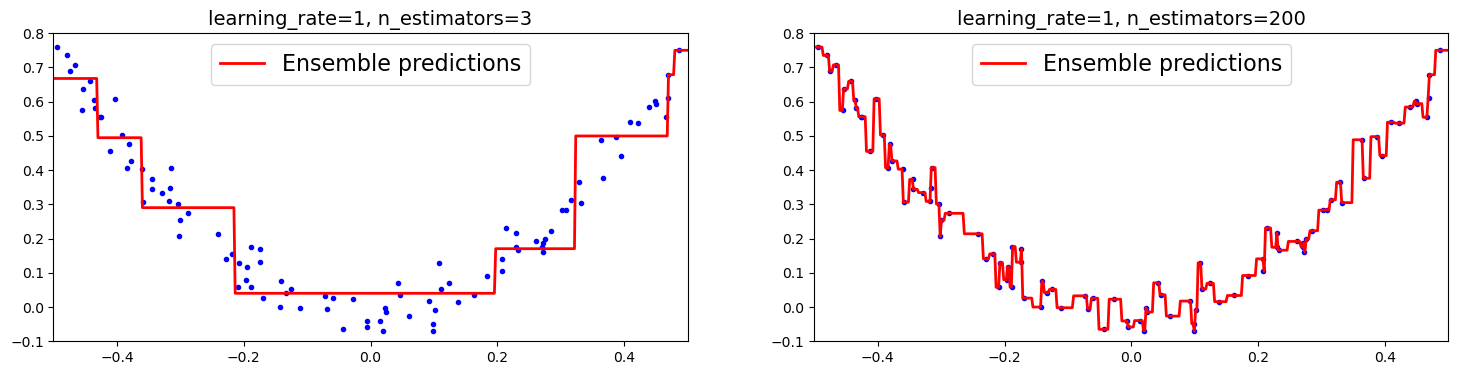

In [23]:
plt.figure(figsize=(18, 4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

<a id="1.3"></a>
## 1.3. Влияние разной глубины базовых алгоритмов на градиентный бустинг

Посмотрим, как изменятся результаты при разной глубине базовых классификаторов 

In [25]:
gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=seed)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=10,
                                      n_estimators=3,
                                      learning_rate=1.0,
                                      random_state=seed)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=10, n_estimators=3,
                          random_state=42)

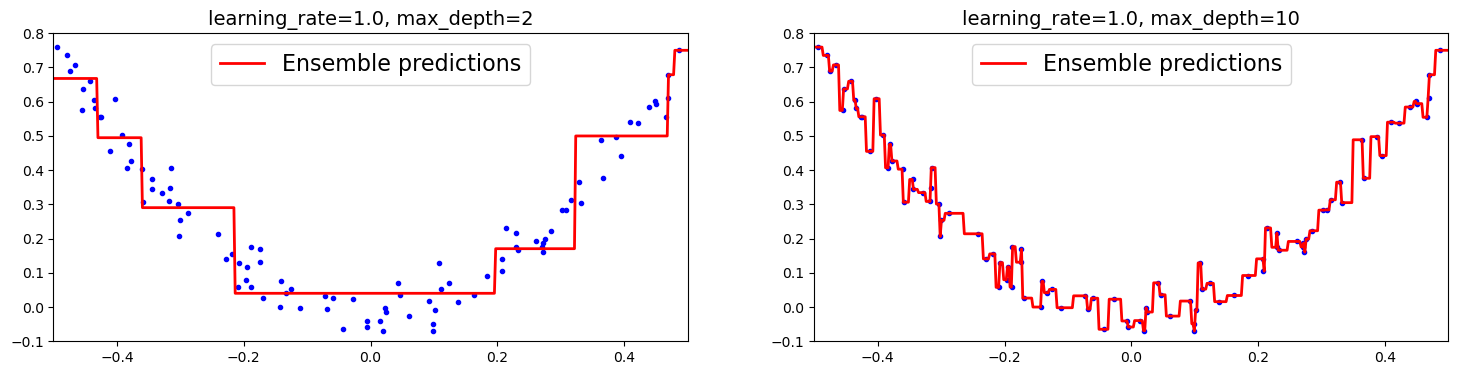

In [26]:
plt.figure(figsize=(18, 4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="Ensemble predictions")
plt.title("learning_rate={}, max_depth={}".format(gbrt.learning_rate, gbrt.max_depth), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="Ensemble predictions")
plt.title("learning_rate={}, max_depth={}".format(gbrt_slow.learning_rate, gbrt_slow.max_depth), fontsize=14)

plt.show()

<a id="1.4"></a>
## 1.4. Методы борьбы с переобучением
Посмотрим, как ведет себя ошибка на каждой итерации

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed)

# init and fit
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=400, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=400, random_state=42)

In [29]:
# get errors on each model
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# определим дерево, на котором произошла минимальная ошибка
best_n_estimators = np.argmin(errors)
print(best_n_estimators)

last_estimator = 400 - 1
print(f'Error on {best_n_estimators} model - {errors[best_n_estimators]}')
print(f'Error on {last_estimator} (last) model - {errors[last_estimator]}')
print(f'Error difference - {errors[best_n_estimators] - errors[last_estimator]}')

275
Error on 275 model - 0.0029677860162253293
Error on 399 (last) model - 0.0030151083382793805
Error difference - -4.732232205405121e-05


In [30]:
# обучим ансамбль на "оптимальном количестве" моделей
gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=best_n_estimators,
                                      random_state=seed)
gbrt_best.fit(X_train, y_train)
min_error = np.min(errors)

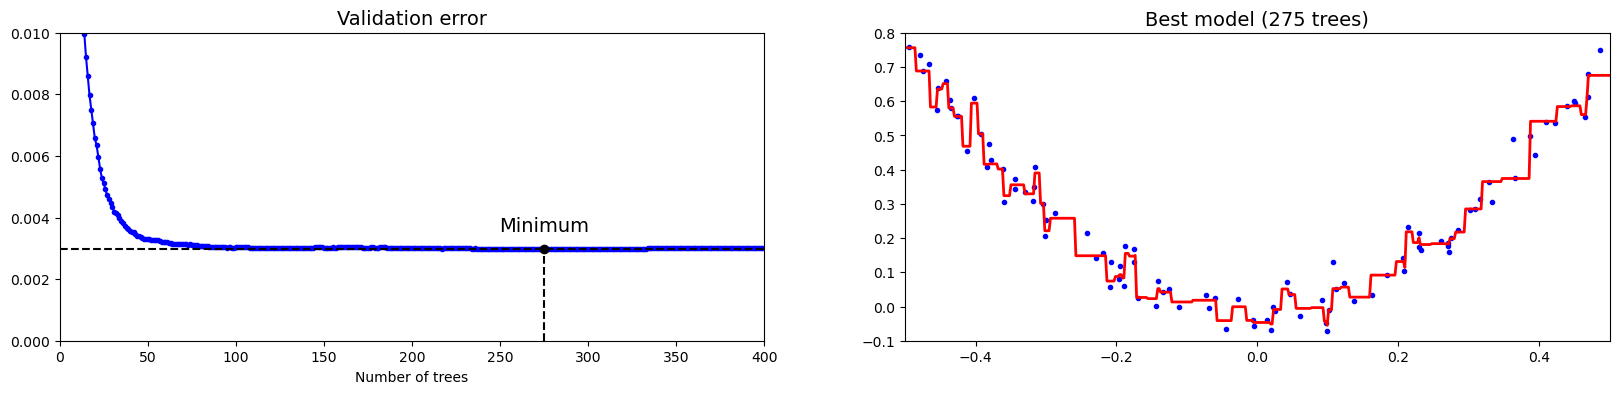

In [31]:
plt.figure(figsize=(20, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 400], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error * 1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 400, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)

plt.show()

<a id="2"></a>
# 2. Фреймворки для градиентного бустинга

<a id="2.1"></a>
## 2.1. LightGBM

In [84]:
!pip install lightgbm==3.2.1

  Obtaining dependency information for lightgbm==3.2.1 from https://files.pythonhosted.org/packages/13/16/0fdf64abd7efa61a7f47b1fe59ad25820384c58abf532e6847e7cd0190d6/lightgbm-3.2.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------

In [32]:
import lightgbm as lgb

In [33]:
# Загрузим данные и проведем предобработки: 
data = pd.read_csv('flight_delays_train.csv')
data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
data['Month'] = data['Month'].str.replace('c-', '').astype('int16')
data['DayofMonth'] = data['DayofMonth'].str.replace('c-', '').astype('int16')
data['DayOfWeek'] = data['DayOfWeek'].str.replace('c-', '').astype('int16')
data['UniqueCarrier'] = pd.factorize(data['UniqueCarrier'])[0]
data['Origin'] = pd.factorize(data['Origin'])[0]
data['Dest'] = pd.factorize(data['Dest'])[0]

# DepTime пусть бдет более вещественным числом (так как 60 минут в часах)
data['DepTime_real'] = data['DepTime'].apply(lambda x: int(x/100)+((x/100-int(x/100))*100)/59)
data.drop('DepTime', axis=1, inplace=True)

x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values

data.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_real
0,8,21,7,0,0,0,732,0,19.576271
1,4,20,3,1,1,1,834,0,15.813559
2,9,2,5,2,2,2,416,0,14.372881
3,11,25,6,3,3,3,872,0,10.254237
4,10,7,6,4,4,4,423,1,18.474576


Разделим выборку на обучающую и тестовую

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7,
                                                    shuffle=True,
                                                    random_state=seed)

Создадим датасеты, как того требует библиотека

In [35]:
trn_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_test, label=y_test)

Укажем параметры, для того чтобы бустинг решал задачу классификации

In [36]:
param = {
    'boost': 'gbdt',
    'metric':'auc',
    'num_threads': 1,
    'objective': 'binary', 
}

Обучим модель

In [38]:
history = {}
clf = lgb.train(param, trn_data, num_boost_round=1000, 
                valid_sets=[trn_data, val_data], 
                # callbacks=[lgb.record_evaluation(eval_result=history), lgb.log_evaluation(100)])
                verbose_eval=100,  evals_result=history)

[LightGBM] [Info] Number of positive: 13313, number of negative: 56687
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190186 -> initscore=-1.448804
[LightGBM] [Info] Start training from score -1.448804
[100]	training's auc: 0.782335	valid_1's auc: 0.738082
[200]	training's auc: 0.823161	valid_1's auc: 0.742565
[300]	training's auc: 0.850599	valid_1's auc: 0.74439
[400]	training's auc: 0.873476	valid_1's auc: 0.746316
[500]	training's auc: 0.893042	valid_1's auc: 0.747661
[600]	training's auc: 0.91053	valid_1's auc: 0.74804
[700]	training's auc: 0.923731	valid_1's auc: 0.747913
[800]	training's auc: 0.935528	valid_1's auc: 0.747237
[900]	training's auc: 0.944872	valid_1's auc: 0.747325
[1000]	train

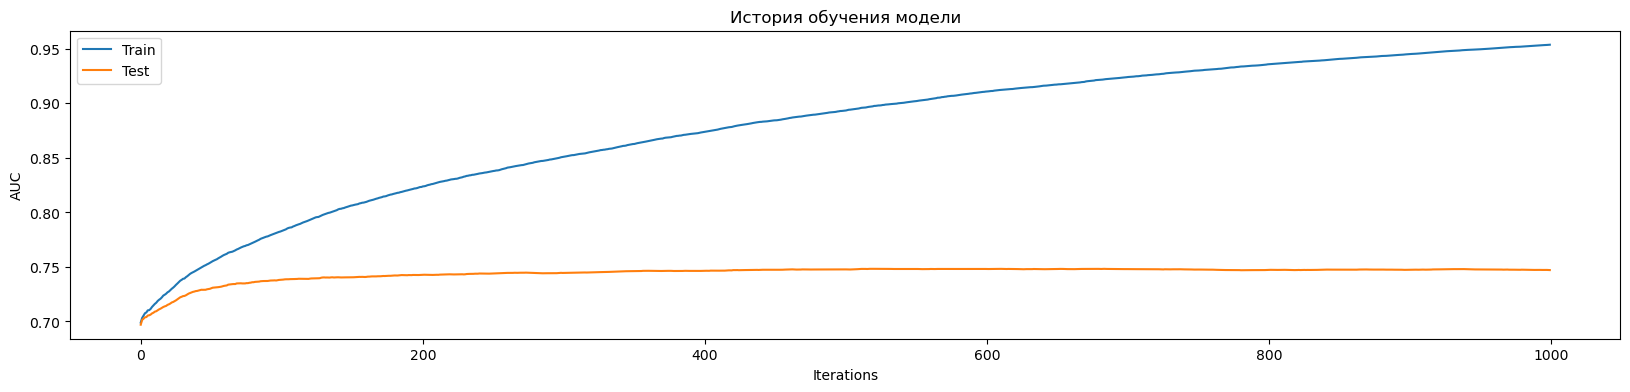

In [39]:
plt.figure(figsize=(20, 4))

plt.plot(history['training']['auc'], label='Train')
plt.plot(history['valid_1']['auc'], label='Test')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('История обучения модели')
plt.legend()

plt.show()

В документации LightGBM есть целый [раздел](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) о том, как тюнить параметры. 
Попробуем улучшить качество. 

In [40]:
c = {
    'boost': 'gbdt',
    'metric':'auc',
    'num_threads': 12,
    'objective': 'binary', 
    'bagging_fraction': 0.7, # Не больше 70% выборки
    'feature_fraction': 0.7, # Не больше 70% фич
    'learning_rate': 0.5, # Установим скорость обучения
    'max_depth': 2, # Ограничим дерево
    'min_data_in_leaf': 100, # Ограничим кол-во объектов в листе 
    'num_leaves': 2, # Ограничим кол-во листьев (Не совсем то, что max_depth)
}

In [42]:
history = {}

# Увеличим кол-во итераций num_boost_round и установим критерий останова early_stopping_rounds
clf = lgb.train(param, trn_data, num_boost_round=3000, 
                valid_sets=[trn_data, val_data],
                # callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.record_evaluation(eval_result=history), lgb.log_evaluation(200)])
                verbose_eval=200,  evals_result=history,
                early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 13313, number of negative: 56687
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190186 -> initscore=-1.448804
[LightGBM] [Info] Start training from score -1.448804
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.823161	valid_1's auc: 0.742565
[400]	training's auc: 0.873476	valid_1's auc: 0.746316
[600]	training's auc: 0.91053	valid_1's auc: 0.74804
Early stopping, best iteration is:
[519]	training's auc: 0.8968	valid_1's auc: 0.748214


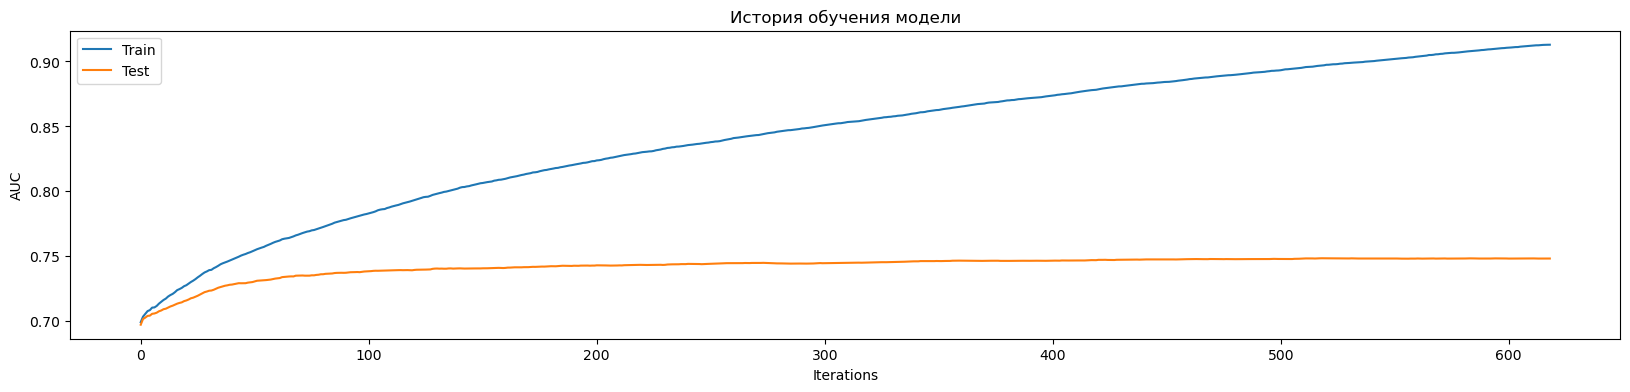

In [43]:
plt.figure(figsize=(20, 4))

plt.plot(history['training']['auc'], label='Train')
plt.plot(history['valid_1']['auc'], label='Test')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('История обучения модели')
plt.legend()

plt.show()

<a id="2.2"></a>
## 2.2. XGboost

In [45]:
# !pip install xgboost
from xgboost import XGBClassifier, DMatrix, train

Описание [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=train#xgboost.XGBClassifier)

In [46]:
params = {
    'n_estimators': 450,
    'colsample_bytree': 0.75,
    'reg_alpha': 1,
    'reg_lambda': 2,
    'subsample': 0.55,
    'learning_rate': 0.5,
    'gamma': 0.5,
    'min_child_weight': 0.01,
    'sampling_method': 'uniform',
    'n_jobs': -1,
    # 'gpu_id ': 0,
    'early_stopping_rounds': 100,
    'eval_metric': 'auc'
}

xgb = XGBClassifier(**params, random_state=seed)

In [47]:
xgb.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)], 
        verbose=True)

[0]	validation_0-auc:0.57779	validation_1-auc:0.56371
[1]	validation_0-auc:0.71300	validation_1-auc:0.70188
[2]	validation_0-auc:0.71974	validation_1-auc:0.70726
[3]	validation_0-auc:0.72363	validation_1-auc:0.71032
[4]	validation_0-auc:0.73069	validation_1-auc:0.71366
[5]	validation_0-auc:0.73315	validation_1-auc:0.71622
[6]	validation_0-auc:0.73712	validation_1-auc:0.71771
[7]	validation_0-auc:0.73985	validation_1-auc:0.72012
[8]	validation_0-auc:0.74356	validation_1-auc:0.72194
[9]	validation_0-auc:0.74534	validation_1-auc:0.72262
[10]	validation_0-auc:0.74845	validation_1-auc:0.72323
[11]	validation_0-auc:0.75098	validation_1-auc:0.72451
[12]	validation_0-auc:0.75437	validation_1-auc:0.72540
[13]	validation_0-auc:0.75644	validation_1-auc:0.72522
[14]	validation_0-auc:0.75719	validation_1-auc:0.72586
[15]	validation_0-auc:0.75983	validation_1-auc:0.72681
[16]	validation_0-auc:0.76156	validation_1-auc:0.72684
[17]	validation_0-auc:0.76279	validation_1-auc:0.72705
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0.01, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
preds = xgb.predict(x_test)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
roc_auc_score(y_test, preds)

0.5670021043653544

<a id="2.3"></a>
## 2.3. CatBoost

In [51]:
# !pip install catboost
from catboost import CatBoostClassifier, Pool

In [52]:
cbc = CatBoostClassifier(random_state=seed, 
                         early_stopping_rounds=100, 
                         task_type="GPU", devices='0:1')

In [53]:
# Загрузим данные и не проведем предобработки: 
data = pd.read_csv('flight_delays_train.csv')
data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)

data.drop('DepTime', axis=1, inplace=True)

x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values

data.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,US,PIT,MCO,834,0
2,c-9,c-2,c-5,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,WN,MDW,OMA,423,1


In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7,
                                                    shuffle=True, 
                                                    random_state=seed)

In [55]:
x_train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance
76513,c-7,c-11,c-2,CO,IAH,DEN,861
60406,c-6,c-27,c-1,WN,LAX,PHX,370
27322,c-7,c-6,c-4,WN,BWI,PHX,1999
53699,c-12,c-5,c-1,NW,DTW,MEM,610
65412,c-9,c-13,c-3,EV,PIT,ATL,526


In [56]:
valid_set = [x_test, y_test]

eval_dataset = Pool(data=x_test,
                    label=y_test,
                    cat_features=[0, 1, 2, 3, 4, 5])

cbc.fit(x_train, y_train, cat_features=[0, 1, 2, 3, 4, 5], eval_set=eval_dataset, 
        verbose=1, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049624
0:	learn: 0.6706493	test: 0.6707572	best: 0.6707572 (0)	total: 81.7ms	remaining: 1m 21s
1:	learn: 0.6507277	test: 0.6510333	best: 0.6510333 (1)	total: 171ms	remaining: 1m 25s
2:	learn: 0.6324699	test: 0.6330499	best: 0.6330499 (2)	total: 245ms	remaining: 1m 21s
3:	learn: 0.6163156	test: 0.6168850	best: 0.6168850 (3)	total: 318ms	remaining: 1m 19s
4:	learn: 0.6020362	test: 0.6028484	best: 0.6028484 (4)	total: 369ms	remaining: 1m 13s
5:	learn: 0.5891065	test: 0.5900875	best: 0.5900875 (5)	total: 423ms	remaining: 1m 10s
6:	learn: 0.5775927	test: 0.5787445	best: 0.5787445 (6)	total: 500ms	remaining: 1m 10s
7:	learn: 0.5674503	test: 0.5686779	best: 0.5686779 (7)	total: 558ms	remaining: 1m 9s
8:	learn: 0.5582088	test: 0.5595221	best: 0.5595221 (8)	total: 625ms	remaining: 1m 8s
9:	learn: 0.5500380	test: 0.5514117	best: 0.5514117 (9)	total: 721ms	remaining: 1m 11s
10:	learn: 0.5424771	test: 0.5437647	best: 0.5437647 (10)	total: 794ms	remaining: 1m 11s
11:	learn: 0

In [57]:
preds = cbc.predict(eval_dataset)

In [58]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [59]:
roc_auc_score(y_test, preds)

0.5066049558143095

<a id="3"></a>
# Полезные ссылки

## Что посмотреть?
1. [AdaBoost на примере деревьев](https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmer)
2. [Gradient Boosting: Regression Main Ideas](https://www.youtube.com/watch?v=3CC4N4z3GJc&ab_channel=StatQuestwithJoshStarmer)

## Что почитать?
1. [Ансамбли в машинном обучении](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)
2. [Как тюнить параметры для LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Документация для XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
4. [CatBoost](https://catboost.ai/)